Author: Zacharias Detorakis
Date: 22-12-2019

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gp
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df_crime = pd.read_csv("MPS_Ward_Level_Crime_Historic_NewWard.csv")
df_crime.head()
df_crime.shape

(20126, 110)

With the crime data loaded we need to melt the multiple years that are currently represented as columns into a signle column that has the year. To do that we create a list with the columns that we need to preserve and a list with the columns that we want to transpose to rows

In [3]:
df_years = list(df_crime.columns)
df_ids = df_years[0:5]
del df_years[0:5]

Then we reshape the dataframe to have a single column YearMonth for all the months and the value which is the number of crimes

In [4]:
df_crime = pd.melt(df_crime, id_vars=df_ids, value_vars=df_years, var_name='YearMonth', value_name='NumberOfCrimes')
df_crime = df_crime.sort_values(by=['WardCode','Minor Category'])


We will also create columns for years and months based on the YearMonth columns which will make aggregations much easier

In [5]:
df_crime['Year'] = df_crime.apply(lambda row: row.YearMonth[0:4], axis = 1)
df_crime['Month'] = df_crime.apply(lambda row: row.YearMonth[4::], axis = 1)

The crime data in this datase are absolute numbers. In order to convert them to rates we need to introduce the population at ward level. The only dataset I could find for that is here https://data.london.gov.uk/dataset/ward-profiles-and-atlas and only countains a number of years in our time frame

In [6]:
df_ward_population = pd.read_csv("ward-atlas-data.csv",skiprows=1)

In [7]:
df_ward_population = df_ward_population[['Codes', 'New Code', 'Names', '2006', '2011', '2013', '2014', '2015', '2016', '2018']]
df_ward_population = pd.melt(df_ward_population, id_vars=['Codes', 'New Code', 'Names'], value_vars=['2006', '2011', '2013', '2014', '2015', '2016', '2018'], var_name='Year', value_name='Population')
df_ward_population = df_ward_population.sort_values(by=['New Code','Year'])

In [8]:
df_ward_population.head(10)

,Codes,New Code,Names,Year,Population
1,00ABFX,E05000026,Abbey,2006,10239
629,00ABFX,E05000026,Abbey,2011,12900
1257,00ABFX,E05000026,Abbey,2013,13806
1885,00ABFX,E05000026,Abbey,2014,14283
2513,00ABFX,E05000026,Abbey,2015,14739
3141,00ABFX,E05000026,Abbey,2016,14986
3769,00ABFX,E05000026,Abbey,2018,15500
2,00ABFY,E05000027,Alibon,2006,9236
630,00ABFY,E05000027,Alibon,2011,10450
1258,00ABFY,E05000027,Alibon,2013,10527


In [9]:
df_crime_final = pd.merge(left = df_crime, right= df_ward_population, how='left', left_on=['WardCode','Year'],right_on=['New Code','Year'])
df_crime_final = df_crime_final[['WardCode','Codes', 'Ward Name','Borough', 'Major Category', 'Minor Category', 'YearMonth', 'Year', 'Month','NumberOfCrimes', 'Population']]
df_crime_final.count() - df_crime_final.isna().sum()

WardCode          2113230
Codes              513042
Ward Name         2113230
Borough           2113230
Major Category    2113230
Minor Category    2113230
YearMonth         2113230
Year              2113230
Month             2113230
NumberOfCrimes    2113230
Population         513042
dtype: int64

After merging the two datasets we need to inspect for nulls. We already know that there are issues with missing years of wards but we need to see if there are certain wards that do not appear in the population dataframe.

In [10]:
missing_crime_wards = list(set(df_crime['WardCode']) - set(df_ward_population['New Code']))
missing_population_wards = list(set(df_ward_population['New Code']) - set(df_crime['WardCode']))

print("There are {} wards missing from the population file".format(len(missing_crime_wards)))

There are 59 wards missing from the population file


In [11]:
# df_missing_crime_wards = df_crime[df_crime['WardCode'].isin(missing_crime_wards)]
# df_missing_crime_wards = df_missing_crime_wards[['WardCode','Ward Name']].sort_values(by='Ward Name')
# list(df_missing_crime_wards['Ward Name'].unique())

In [12]:
# df_missing_population_wards = df_ward_population[df_ward_population['New Code'].isin(missing_population_wards)]
# df_missing_population_wards = df_missing_population_wards[['New Code','Names']].sort_values(by='Names')
# list(df_missing_population_wards['Names'].unique())

For the time being we are going to filter out those 59 wards out of the list of 629 wards in our original dataset with crime data since we do not have any details on the population on those wards

In [13]:
df_crime_final_clean = df_crime_final[~df_crime_final.WardCode.isin(missing_crime_wards)]

And to prove that we've cleaned the data from any incompatible wards we check the uniques years on the records that are missing a ward code and observe that these are only for the three years that are missing from the population dataset.

In [14]:
list(df_crime_final_clean[df_crime_final_clean['Codes'].isnull()]['Year'].unique())

['2010', '2012', '2017']

Our final step before start visualising the results is to add values for the population in 2010, 2012 and 2017 which are the missing years. However it looks like we have lots of missing values which cannot be justified by the above assumption sin we are missing more than half of the values for the population but only 1/3 of the years. time for some visualisation

In [15]:
df_crime_final_clean.groupby(by='Year')['Population'].sum()

Year
2010    0.000000e+00
2011    2.898011e+09
2012    0.000000e+00
2013    2.973815e+09
2014    3.007000e+09
2015    3.039568e+09
2016    3.071377e+09
2017    0.000000e+00
2018    3.133194e+09
Name: Population, dtype: float64

In [16]:
#We get the columns with the ward ids the year and the populaton
df_for_imputation = df_crime_final_clean[['WardCode','Year','Population']]
print(df_for_imputation.shape)
# remove any duplicates
df_for_imputation = df_for_imputation.drop_duplicates()
print(df_for_imputation.shape)
# and then update the NaN values. For 2010 since we have no prior data we get the same value of the population from 2010 whereas for the other other two missing years we get the average
df_for_imputation = pd.DataFrame(df_for_imputation.pivot(index='WardCode',columns='Year', values='Population'))
df_for_imputation['2010']=df_for_imputation['2011']
df_for_imputation['2012']=(df_for_imputation['2011']+df_for_imputation['2013'])/2
df_for_imputation['2017']=(df_for_imputation['2016']+df_for_imputation['2018'])/2

(1914990, 3)
(5130, 3)


In [17]:
df_for_imputation.reset_index(inplace=True)
df_for_imputation = pd.melt(df_for_imputation,id_vars=['WardCode'], value_vars=['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'], var_name='Year', value_name='PopulationImputed')

Finally we melt the dataframe to make sure it is ready for imputation

In [18]:
df_for_imputation.head()

,WardCode,Year,PopulationImputed
0,E05000026,2010,12900.0
1,E05000027,2010,10450.0
2,E05000028,2010,11650.0
3,E05000029,2010,10100.0
4,E05000030,2010,10600.0


In [19]:
df_crime_imputed = pd.merge(left = df_crime_final_clean, right= df_for_imputation, how='inner', left_on=['WardCode','Year'],right_on=['WardCode','Year'])

In [20]:
df_crime_imputed.groupby(by='Year')['PopulationImputed'].sum()

Year
2010    2.173509e+09
2011    2.898011e+09
2012    2.935913e+09
2013    2.973815e+09
2014    3.007000e+09
2015    3.039568e+09
2016    3.071377e+09
2017    3.102285e+09
2018    3.133194e+09
Name: PopulationImputed, dtype: float64

# Data Visualization
## Temporal

We will first start with observing the trend of crimimal rates overtime to see if there are any general patterns that are seasonal

In [21]:
df_crime_by_YearMonth = df_crime_imputed.groupby(by=['YearMonth','Year','Month']).sum()

In [22]:
df_crime_by_YearMonth['CrimeRate'] = df_crime_by_YearMonth['NumberOfCrimes']/df_crime_by_YearMonth['PopulationImputed']
df_crime_by_YearMonth.drop(labels = 'Population',axis=1, inplace=True)

In [23]:
df_crime_by_YearMonth.reset_index(inplace=True)
df_crime_by_YearMonth = df_crime_by_YearMonth[['YearMonth','CrimeRate']]
df_crime_by_YearMonth = df_crime_by_YearMonth.rename(columns={"CrimeRate": "CrimeRateTotal"})

In [24]:
df_crime_by_YearMonth.head()

,YearMonth,CrimeRateTotal
0,201004,0.000249
1,201005,0.000256
2,201006,0.000258
3,201007,0.000261
4,201008,0.000240


In [25]:
df_crime_by_YearMonth_MajorCategory = df_crime_imputed.groupby(by=['YearMonth','Year','Month','Major Category']).sum()
df_crime_by_YearMonth_MajorCategory['CrimeRate'] = df_crime_by_YearMonth_MajorCategory['NumberOfCrimes']/df_crime_by_YearMonth_MajorCategory['PopulationImputed']
df_crime_by_YearMonth_MajorCategory.drop(labels = 'Population',axis=1, inplace=True)

df_crime_by_YearMonth_MajorCategory.reset_index(inplace=True)
df_crime_by_YearMonth_MajorCategory = df_crime_by_YearMonth_MajorCategory[['YearMonth','Major Category','CrimeRate']]
df_crime_by_YearMonth_MajorCategory = pd.DataFrame(df_crime_by_YearMonth_MajorCategory.pivot(index='YearMonth', columns='Major Category', values='CrimeRate'))
df_crime_by_YearMonth_MajorCategory.reset_index(inplace=True)

In [26]:
df_crime_by_YearMonth_MajorCategory.head()

Major Category,YearMonth,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offences,Robbery,Sexual Offences,Theft and Handling,Violence Against The Person
0,201004,0.000441,0.000230,0.000193,0.000106,0.000062,0.000176,0.000044,0.000391,0.000242
1,201005,0.000441,0.000223,0.000200,0.000111,0.000064,0.000194,0.000054,0.000392,0.000262
2,201006,0.000435,0.000231,0.000192,0.000111,0.000064,0.000174,0.000052,0.000400,0.000267
3,201007,0.000437,0.000227,0.000223,0.000122,0.000067,0.000166,0.000051,0.000399,0.000270
4,201008,0.000444,0.000207,0.000227,0.000111,0.000058,0.000148,0.000042,0.000367,0.000234


In [27]:
temporal_crime = pd.merge(left=df_crime_by_YearMonth_MajorCategory, right=df_crime_by_YearMonth, on='YearMonth')

In [28]:
temporal_crime = temporal_crime.set_index('YearMonth')

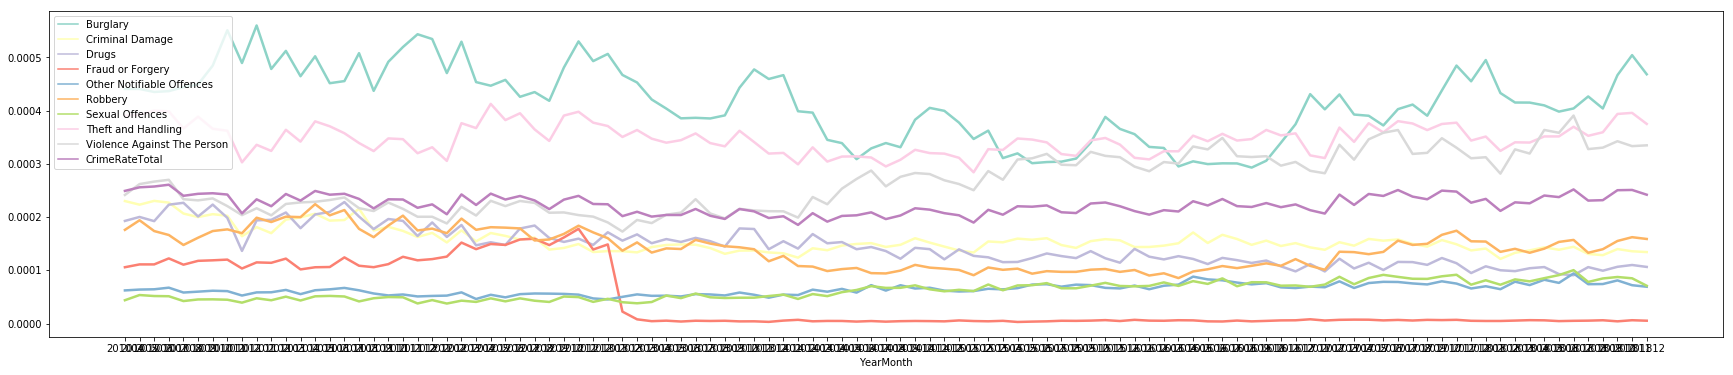

In [29]:
plt.figure(figsize=(30, 6))
sns.lineplot(data=temporal_crime, dashes=False ,linewidth=2.5, palette="Set3")

In [30]:
temporal_crime_melted = pd.melt(temporal_crime, value_vars=['Burglary', 'Criminal Damage', 'Drugs', 'Fraud or Forgery',
       'Other Notifiable Offences', 'Robbery', 'Sexual Offences',
       'Theft and Handling', 'Violence Against The Person', 'CrimeRateTotal'], value_name='CrimeRate', var_name='MajorCategory')

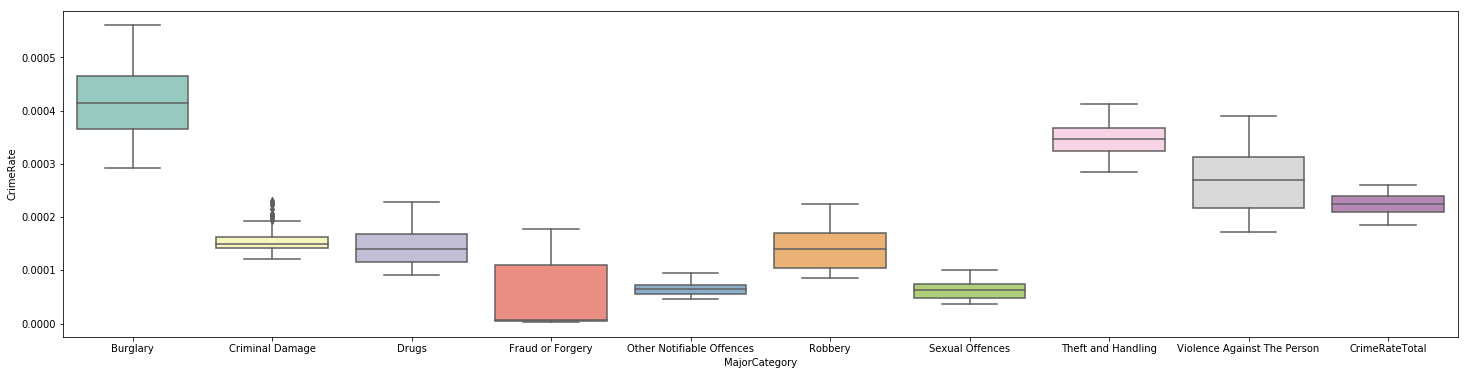

In [31]:
plt.figure(figsize=(25, 6))
sns.boxplot(x="MajorCategory", y="CrimeRate", data=temporal_crime_melted, palette="Set3")

So we will be selecting the categories of 'Burglary', 'Theft and Handling' and 'Violence Against the person' as these are the categories with highest rates and aslo they seem to have the highest standard deviation overtime so we might be able to observe other changes over the same period of time 

In [32]:
temporal_crime.describe()

,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offences,Robbery,Sexual Offences,Theft and Handling,Violence Against The Person,CrimeRateTotal
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,0.000414,0.000157,0.000145,0.000045,0.000065,0.000141,0.000062,0.000348,0.000267,0.000224
std,0.000068,0.000024,0.000036,0.000058,0.000010,0.000035,0.000016,0.000028,0.000053,0.000017
min,0.000293,0.000121,0.000091,0.000003,0.000045,0.000085,0.000038,0.000284,0.000173,0.000185
25%,0.000366,0.000142,0.000115,0.000005,0.000056,0.000105,0.000048,0.000324,0.000217,0.000210
50%,0.000415,0.000150,0.000140,0.000006,0.000064,0.000141,0.000063,0.000347,0.000269,0.000224
75%,0.000465,0.000163,0.000168,0.000111,0.000072,0.000170,0.000074,0.000367,0.000313,0.000240
max,0.000560,0.000231,0.000228,0.000178,0.000094,0.000224,0.000100,0.000413,0.000391,0.000261


In [33]:
temporal_crime = temporal_crime[['Burglary','Theft and Handling','Violence Against The Person']]
temporal_crime.reset_index(inplace=True)

In [34]:
def dt_parse(timestamp_str):
    return pd.to_datetime(timestamp_str, format='%Y%m', errors='coerce')

temporal_crime['YearMonthDate'] = temporal_crime.apply(lambda row: dt_parse(row.YearMonth), axis = 1)
temporal_crime['Year'] = temporal_crime.apply(lambda row: row.YearMonth[0:4], axis = 1)

C:\Users\zacharias.detorakis\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


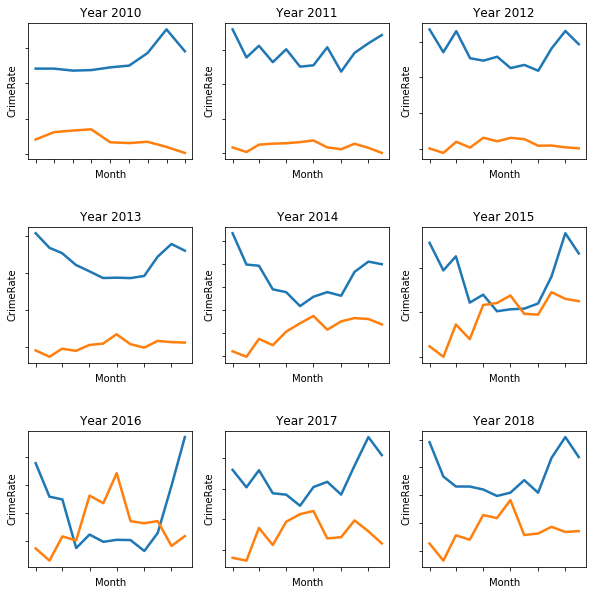

In [35]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))
import math

years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']
i=0;

plt.subplots_adjust(hspace = .5)

for year in years:
    sns.lineplot(data=temporal_crime[['Burglary','Theft and Handling','Violence Against The Person']][temporal_crime['Year']==year]
             , x=temporal_crime['YearMonthDate']
             , y='Burglary'
             , dashes=False 
             , linewidth=2.5
             , palette="Set3"
             , ax = axs[math.floor(i/3), i%3]
                )
    sns.lineplot(data=temporal_crime[['Burglary','Theft and Handling','Violence Against The Person']][temporal_crime['Year']==year]
             , x=temporal_crime['YearMonthDate']
             , y='Violence Against The Person'
             , dashes=False ,linewidth=2.5
             , palette="Set3"
             , ax = axs[math.floor(i/3), i%3]
                )
    axs[math.floor(i/3), i%3].set_title('Year {}'.format(years[i]))
    axs[math.floor(i/3), i%3].set_ylabel('CrimeRate')
    axs[math.floor(i/3), i%3].set_xlabel('Month')
    axs[math.floor(i/3), i%3].set_yticklabels([])
    axs[math.floor(i/3), i%3].set_xticklabels([])
    i+=1
    
plt.show()

<Figure size 432x432 with 0 Axes>

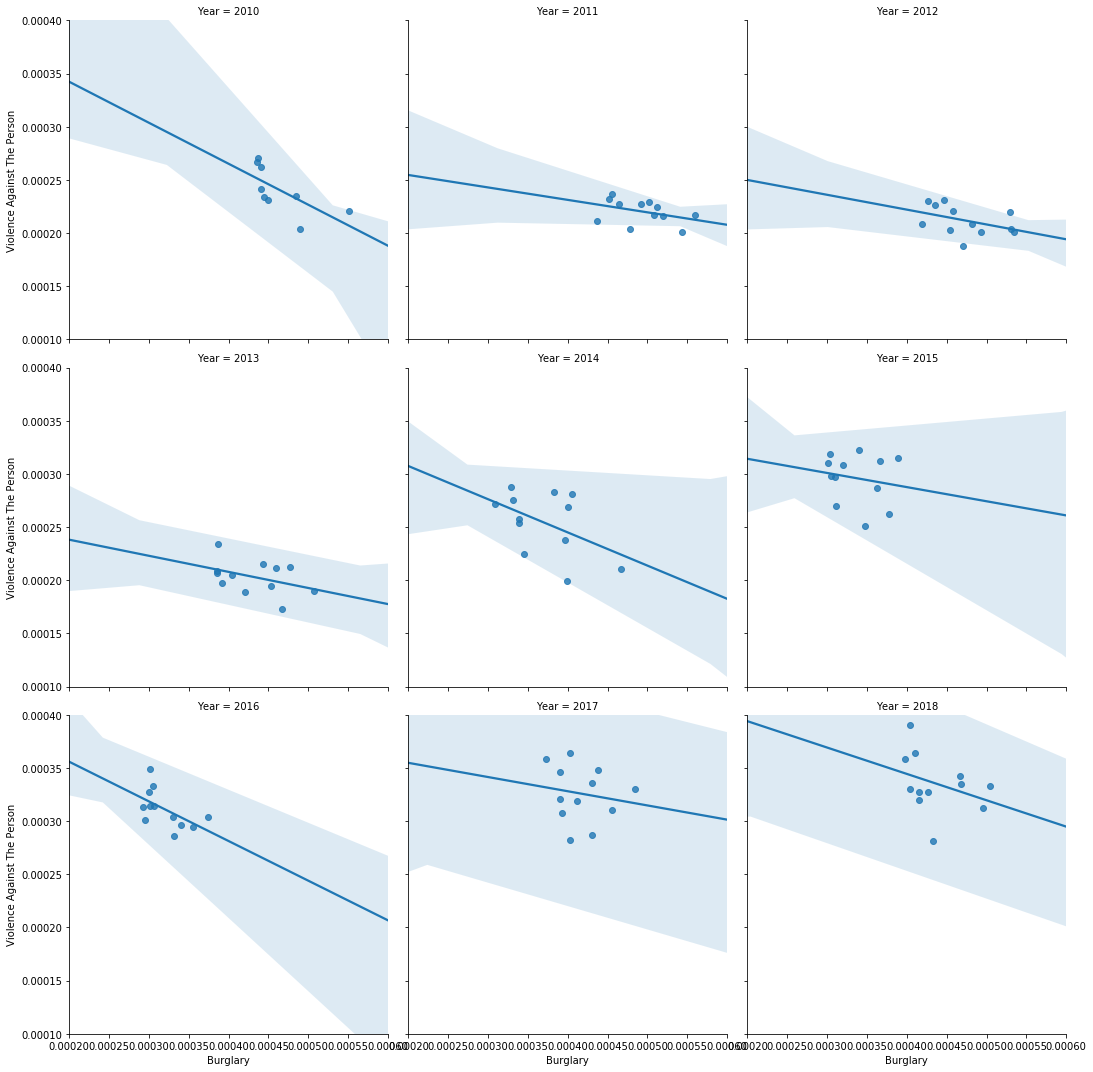

In [36]:
plt.figure(figsize=(6, 6))
ax = sns.lmplot(x="Burglary", y="Violence Against The Person"
                , data=temporal_crime[['Burglary','Theft and Handling','Violence Against The Person','Year']]
                , palette='Set3'
                , col = 'Year'
                , col_wrap=3)
ax.set(xlim=(0.0002, 0.0006))
ax.set(ylim=(0.0001, 0.0004))

plt.show()

In [38]:
wards=gp.read_file('london_wards_2011_wgs84.shp')

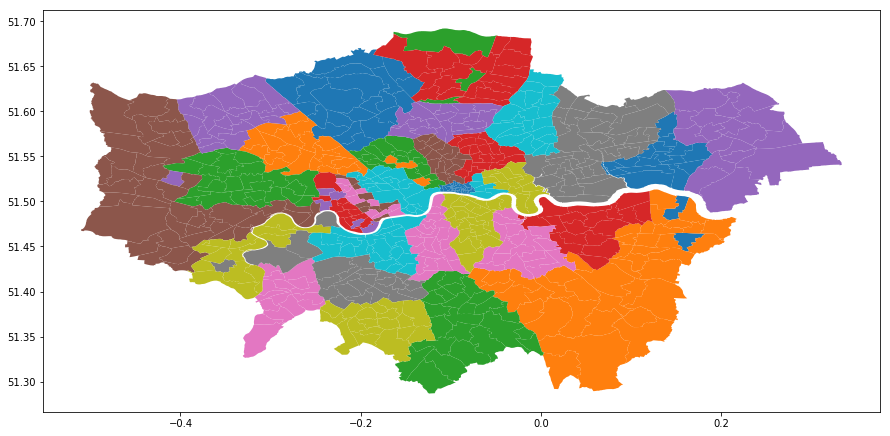

In [40]:
wards.plot(column='CODE', figsize=(15,10));
plt.show()

In [81]:
temp = df_crime_imputed#.groupby(by=['WardCode','Major Category','Year']).sum()

In [85]:
temp.sort_values(by='WardCode',inplace=True)

In [124]:
# frames=[wards,df_crime_imputed]
# data=pd.concat(frames,axis=1)
data = pd.merge(left=wards, right=df_crime_imputed, left_on='CODE', right_on='WardCode')
datann=data[(data['WardCode'].notnull()) & (data['Year']=='2018') & (data['Major Category'] == 'Burglary')];
datann.describe()

,NumberOfCrimes,Population,PopulationImputed
count,13680.000000,13680.000000,13680.000000
mean,6.253874,14315.701754,14315.701754
std,5.298111,3206.748760,3206.748760
min,0.000000,5800.000000,5800.000000
25%,3.000000,11900.000000,11900.000000
50%,5.000000,14000.000000,14000.000000
75%,8.000000,16200.000000,16200.000000
max,114.000000,33800.000000,33800.000000


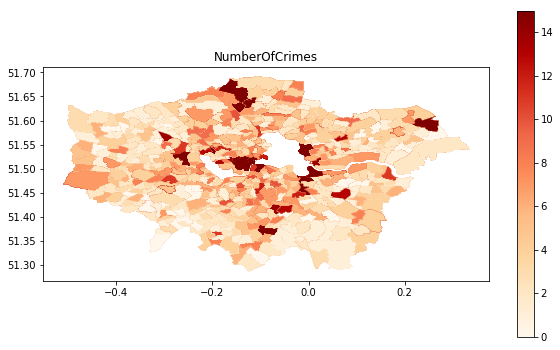

In [130]:
datann.crs = {'init' :'epsg:4326'}
attr="NumberOfCrimes";
ax=datann.plot(column=attr, cmap='OrRd', legend=True, figsize=(10,6)
               , vmax = 15
              );
ax.set_title(attr);
plt.show()

In [125]:
datann.shape

(13680, 17)